In [74]:
# import opendatasets as op
# import json

In [75]:
# datasets = "https://www.kaggle.com/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset"
# op.download(datasets)

In [76]:
# import library
import torch, cv2, os, random,  numpy as np, albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from albumentations.pytorch import ToTensorV2
from glob import glob
from torchvision import transforms as T
import segmentation_models_pytorch  as smp, time
from tqdm import tqdm

In [77]:
class CustomSegDental(Dataset):
    def __init__(self, root, data, transformations = None, im_type = [".jpg", '.png', 'jpeg']):
        super(). __init__()
        self.transformations = transformations
        self.n_class = 2
        self.im_path = sorted(glob(f"{root}/{data}/images/*.png"))
        self.gt_path = sorted(glob(f"{root}/{data}/mask/*.png"))
    
    def __len__(self): return len(self.im_path)
    
    def __getitem__(self, idx):
        im = cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.gt_path[idx]), cv2.COLOR_BGR2GRAY)
        if self.transformations:
            transformed = self.transformations(image = im, mask = gt)
            im = transformed['image']
            gt = transformed["mask"]
        return im, (gt<105).unsqueeze(0).long()

def get_dl(root, bs, transformations = None, split = [0.9, 0.1]):
    tr_ds = CustomSegDental(root = root, data = "train", transformations = transformations)
    ts_ds = CustomSegDental(root = root, data = "test", transformations = transformations)
    n_class = tr_ds.n_class 
    
    # splt to train and validation dataset
    
    tr_len = int(len(tr_ds)*split[0])
    val_len = len(tr_ds) - tr_len
    tr_ds, val_ds = torch.utils.data.random_split(tr_ds, [tr_len, val_len])
    print(f"Numbers of train datasets are {len(tr_ds)}")
    print(f"Numbers of validarion datasets are {len(val_ds)}")
    print(f"Numbers of train datasets are {len(ts_ds)}")
    
    # get dataloader
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(dataset = val_ds, batch_size=bs, shuffle=False, num_workers=0)
    ts_dl = DataLoader(dataset = ts_ds, batch_size=1, shuffle=False, num_workers=0)
    return tr_dl, val_dl, ts_dl, n_class
root = "childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset"


mean, std= [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformator = A.Compose([A.Resize(224,224),
                    A.Normalize(mean =mean, std=std), 
                     ToTensorV2(transpose_mask=True)], is_check_shapes=False) 
tr_dl, val_dl, ts_dl, n_class = get_dl(root = root,  bs = 16, transformations=transformator)  
print(transformator)

Numbers of train datasets are 63
Numbers of validarion datasets are 7
Numbers of train datasets are 30
Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=True),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False)


## `Data Visualization`

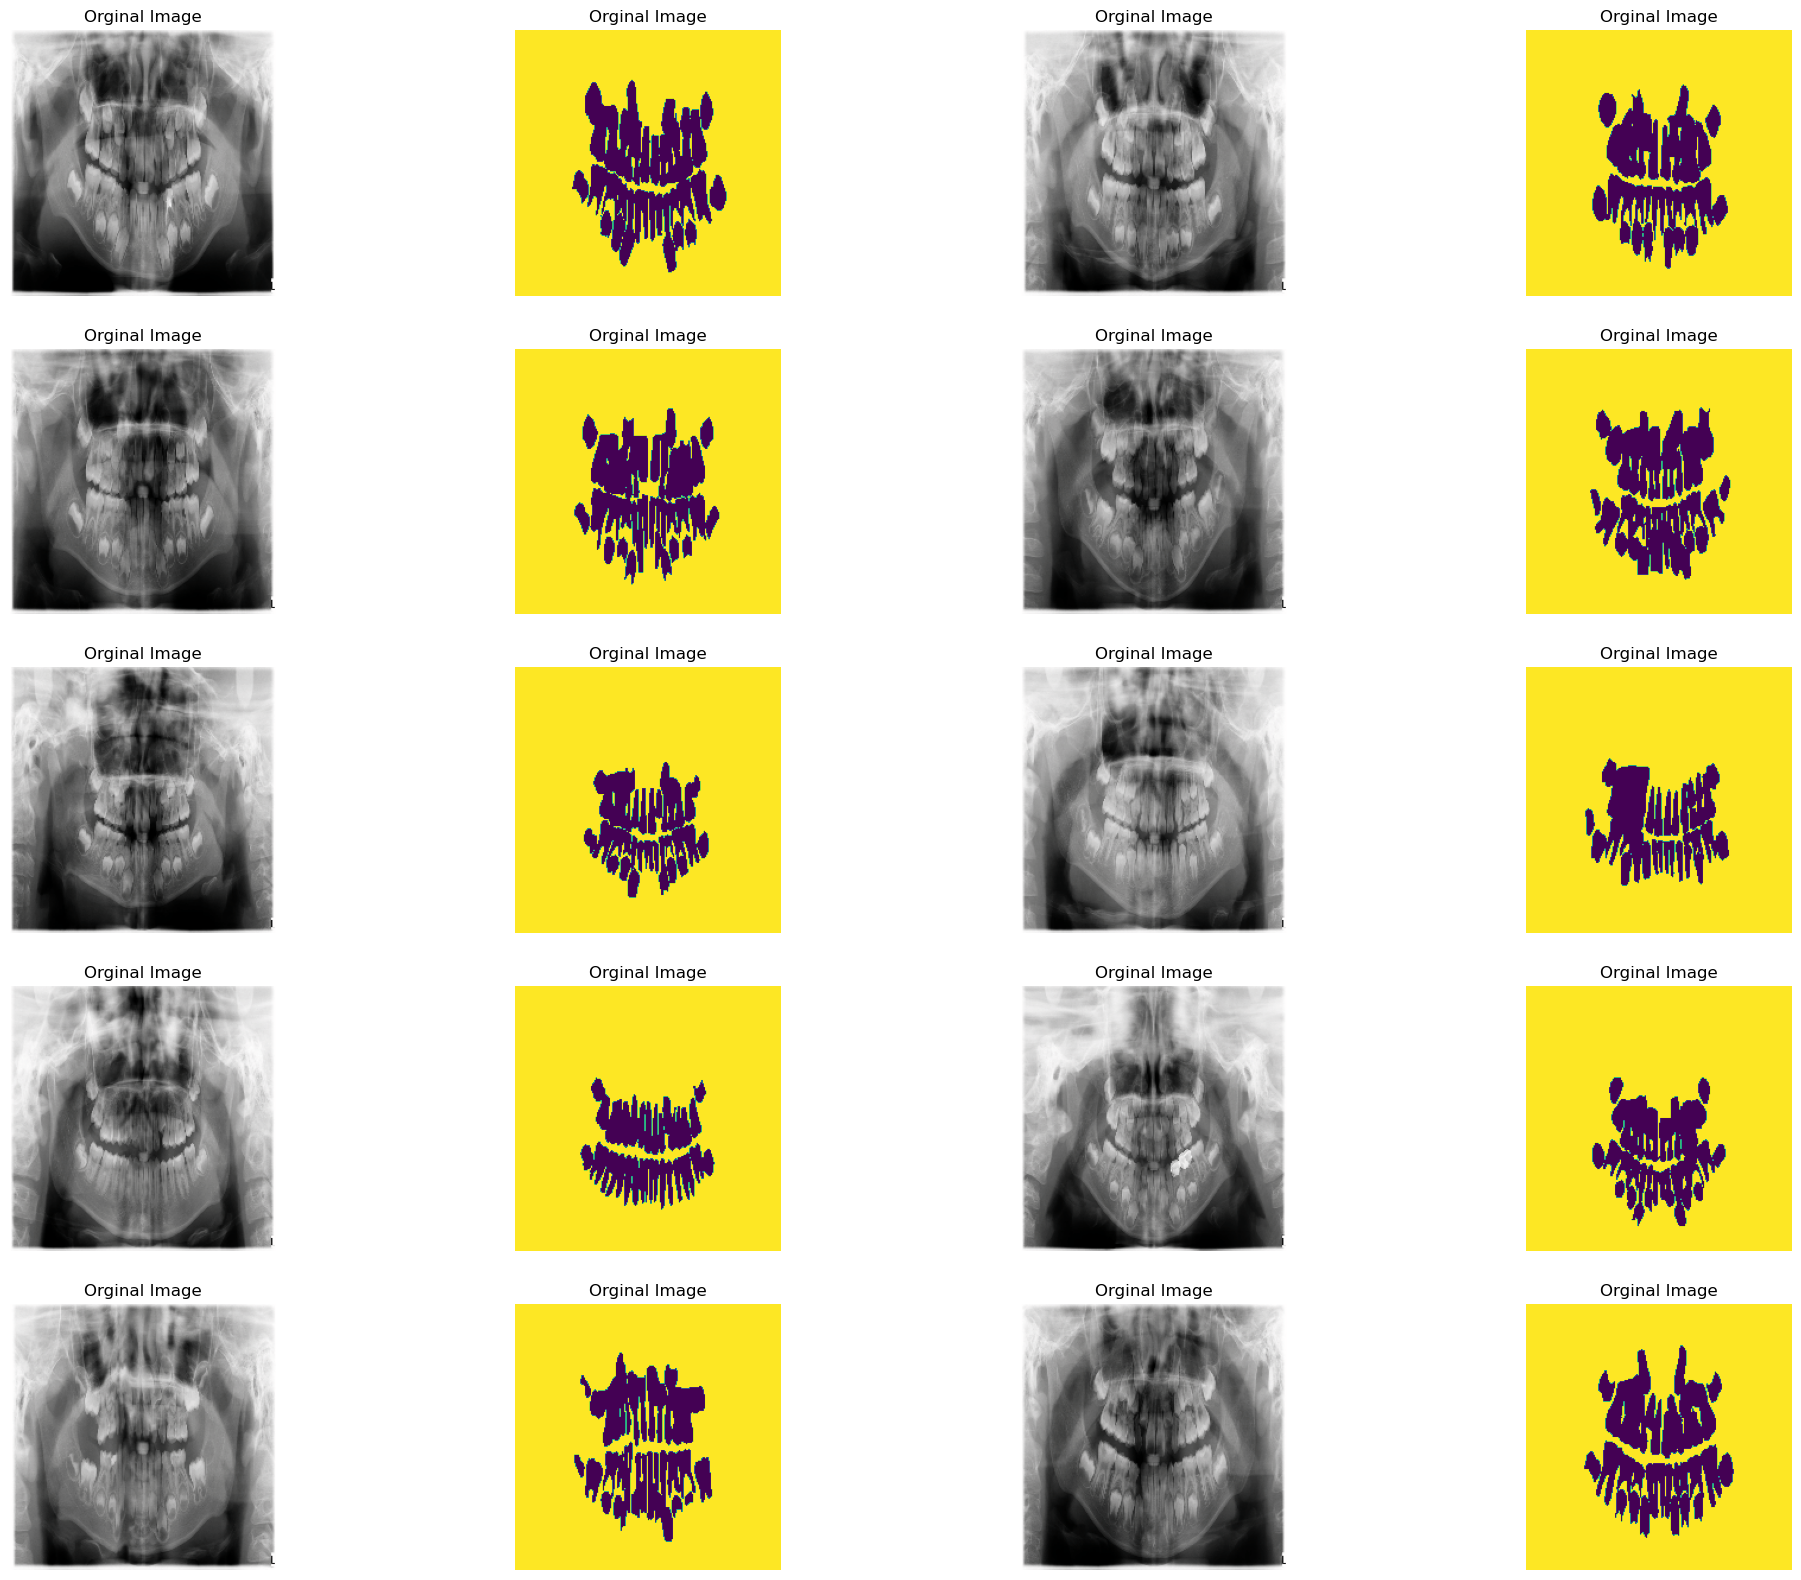

In [78]:
def tn_2_np(t):
    trs = T.Compose([T.Normalize(mean = [0.,0.,0.], std= [1/0.229, 1/0.224, 1/0.225]),
        T.Normalize(mean = [-0.485, -0.456, -0.406], std = [1.,1.,1.])
    ])
  
    rgb = True if len(t) == 3 else False
    return (trs(t)*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb  else (t*255).detach().cpu().numpy().astype(np.uint8)
    
def ploting(rows, colsm, count, im, gt = None, title = "Orginal Image" ):
    
    plt.subplot(rows, colsm, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0))); plt.title(title)
    plt.axis("off")
    return count + 1

def Visualize(ds, num_im):
    plt.figure(figsize=(25, 20))
    rows = num_im//4
    colsm = num_im//rows
    count =1
    indices = [random.randint(0, len(ds)-1) for _ in range(num_im)]
    
    
    for ind, index in enumerate(indices):
        if count == num_im+1: break
        im, gt = ds[ind]
        count = ploting(rows, colsm, count, im = im)
        count = ploting(rows, colsm, count, im = gt, gt = True)

Visualize(ds = tr_dl.dataset, num_im=20)

# `Model`

In [79]:
# model =smp.DeepLabV3Plus(classes=n_class)
model = smp.Unet(encoder_name = "resnet18", classes = 2, encoder_depth = 5, 
                 encoder_weights = "imagenet", activation = None, decoder_channels= [256, 128, 64, 32, 16])
def set_up(model): return "cuda" if torch.cuda.is_available() else "cpu", model.to('cuda'), torch.optim.Adam(params=model.parameters(), lr=3e-3), torch.nn.CrossEntropyLoss(), 20 
device, model, optimizer, loss_fn, epochs = set_up(model)

In [80]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps = 3e-4,  number_class = 2):
        # self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim=1)
        self.pred, self.gt = torch.argmax(pred, dim = 1), gt
        self.pred_ = pred
        self.gt =gt.squeeze(1)
        # print(self.pred_.shape)
        # print(self.gt.shape)
        self.loss_fn = loss_fn
        self.eps = eps
        self.number_class = number_class
    def to_contiguos(self, inp): return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            PA = torch.eq(self.pred, self.gt).int()
        return float(PA.sum())/float(PA.numel())
    
    def mIoU(self):
        pred, gt = self.to_contiguos(self.pred), self.to_contiguos(self.gt)
        IoU_class = []
        for a in range(self.number_class):
            mutch_pred = pred==a
            mutch_gt = gt==a
            if mutch_pred.long().sum().item() ==0 : IoU_class.append(np.nan)
            else:
                intersection = torch.logical_and(mutch_pred, mutch_gt).sum().float().item()
                union = torch.logical_or(mutch_pred, mutch_gt).sum().float().item()
                iou = intersection/(union + self.eps)
                IoU_class.append(iou)
            return np.nanmean(IoU_class)
    def loss(self):
        return self.loss_fn(self.pred_, self.gt)
        
def tic_toc(start_time = None): return time.time() if start_time  == None else time.time() - start_time


## `Train Process!`

In [81]:
def train(model, tr_dl, val_dl, epochs, device, loss_fn, opt, save_prefix, threshold=0.01, save_file=None, patience=5):
    
    tr_loss, tr_IoU, tr_pa = [], [], []
    val_loss, val_IoU, val_pa = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = np.inf
    model.to(device)
    no_improve_epochs = 0  # Counter for early stopping
    
    print(f"Train is starting ..............")
    start_time = time.time()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=2, verbose=True)
    
    for epoch in range(epochs):
        
        tic = tic_toc()
        
        tr_loss_, tr_iou_, tr_pa_ = 0,0,0
        model.train()
        
        print(f"{epoch+1} - Epoch train process is starting.......")
        
        for idx, batch in enumerate(tqdm(tr_dl)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            # print(pred.shape)
            
            met = Metrics(pred, gt, loss_fn )
            
            loss_ = met.loss()
            tr_loss_+= met.loss().item()
            tr_iou_ += met.mIoU()
            tr_pa_  += met.PA()
            
            opt.zero_grad()
            loss_.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            opt.step()
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_  /= tr_len
        
        tr_loss.append(tr_loss_);  tr_IoU.append(tr_iou_); tr_pa.append(tr_pa_)
        
        print(f"{epoch+1} - Epoch Validation process is starting.......")
        val_loss_, val_IoU_, val_pa_  = 0,0,0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                met = Metrics(pred, gt, loss_fn)
                val_loss_ += met.loss().item()
                val_IoU_+= met.mIoU()
                val_pa_ += met.PA()
            val_loss_ /= val_len
            val_IoU_ /= val_len
            val_pa_  /= val_len
            
            val_loss.append(val_loss_); val_IoU.append(val_IoU_); val_pa.append(val_pa_)
            
            scheduler.step(val_loss_)
            
            print("\n ------------------------------------------")
            print(f"{epoch+1} - epoch train result: \n")
            print(f"Train Time         -> {tic_toc(tic):.3f} secs")
            print(f"Train loss                 --> {tr_loss_:.3f}")
            print(f"Train PA                   --> {tr_pa_:.3f}")
            print(f"Train mIoU                 --> {tr_iou_:.3f}\n")
            print(f"Validation loss            --> {val_loss_:.3f}")
            print(f"Validation PA              --> {val_pa_:.3f}")
            print(f"Validation mIoU            --> {val_IoU_:.3f}\n")
            
            if best_loss > (val_loss_ + threshold):
                best_loss = val_loss_
                no_improve_epochs = 0
                if save_file:
                    os.makedirs(save_file, exist_ok=True)
                    torch.save(model.state_dict(), f"{save_file}/{save_prefix}_best.pt")
            else:
                no_improve_epochs += 1
                
            if no_improve_epochs >= patience:
                
                print(f" Stopping train process because loss value did not decrease for {no_improve_epochs} - epochs")
                break
            
    return {"tr_loss": tr_loss, "tr_IoU": tr_IoU, "tr_pa":tr_pa, "val_loss": val_loss, "val_IoU": val_IoU, "val_pa":val_pa}
                    
result = train(model =model, tr_dl = tr_dl, val_dl = val_dl, epochs =epochs , device=device, loss_fn = loss_fn, opt = optimizer, save_prefix = "Dental_Caries",  save_file = "Dental_best_model")     

C:\Users\oybek\anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train is starting ..............
1 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


1 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



 ------------------------------------------
1 - epoch train result: 

Train Time         -> 3.503 secs
Train loss                 --> 0.599
Train PA                   --> 0.741
Train mIoU                 --> 0.235

Validation loss            --> 0.372
Validation PA              --> 0.870
Validation mIoU            --> 0.407

2 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


2 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



 ------------------------------------------
2 - epoch train result: 

Train Time         -> 3.241 secs
Train loss                 --> 0.274
Train PA                   --> 0.897
Train mIoU                 --> 0.504

Validation loss            --> 0.209
Validation PA              --> 0.914
Validation mIoU            --> 0.628

3 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


3 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]



 ------------------------------------------
3 - epoch train result: 

Train Time         -> 3.219 secs
Train loss                 --> 0.170
Train PA                   --> 0.928
Train mIoU                 --> 0.664

Validation loss            --> 0.162
Validation PA              --> 0.933
Validation mIoU            --> 0.691

4 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


4 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]



 ------------------------------------------
4 - epoch train result: 

Train Time         -> 3.262 secs
Train loss                 --> 0.139
Train PA                   --> 0.941
Train mIoU                 --> 0.700

Validation loss            --> 0.143
Validation PA              --> 0.941
Validation mIoU            --> 0.712

5 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


5 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]



 ------------------------------------------
5 - epoch train result: 

Train Time         -> 3.263 secs
Train loss                 --> 0.131
Train PA                   --> 0.943
Train mIoU                 --> 0.703

Validation loss            --> 0.149
Validation PA              --> 0.938
Validation mIoU            --> 0.701

6 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s]


6 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]



 ------------------------------------------
6 - epoch train result: 

Train Time         -> 3.297 secs
Train loss                 --> 0.122
Train PA                   --> 0.947
Train mIoU                 --> 0.728

Validation loss            --> 0.136
Validation PA              --> 0.943
Validation mIoU            --> 0.717

7 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]


7 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



 ------------------------------------------
7 - epoch train result: 

Train Time         -> 3.216 secs
Train loss                 --> 0.114
Train PA                   --> 0.950
Train mIoU                 --> 0.738

Validation loss            --> 0.128
Validation PA              --> 0.946
Validation mIoU            --> 0.734

8 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


8 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]



 ------------------------------------------
8 - epoch train result: 

Train Time         -> 3.244 secs
Train loss                 --> 0.107
Train PA                   --> 0.953
Train mIoU                 --> 0.748

Validation loss            --> 0.120
Validation PA              --> 0.950
Validation mIoU            --> 0.747

9 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


9 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



 ------------------------------------------
9 - epoch train result: 

Train Time         -> 3.286 secs
Train loss                 --> 0.102
Train PA                   --> 0.955
Train mIoU                 --> 0.758

Validation loss            --> 0.114
Validation PA              --> 0.952
Validation mIoU            --> 0.756

10 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


10 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]



 ------------------------------------------
10 - epoch train result: 

Train Time         -> 3.261 secs
Train loss                 --> 0.101
Train PA                   --> 0.956
Train mIoU                 --> 0.758

Validation loss            --> 0.115
Validation PA              --> 0.951
Validation mIoU            --> 0.753

11 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


11 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]



 ------------------------------------------
11 - epoch train result: 

Train Time         -> 3.275 secs
Train loss                 --> 0.097
Train PA                   --> 0.956
Train mIoU                 --> 0.762

Validation loss            --> 0.109
Validation PA              --> 0.955
Validation mIoU            --> 0.765

12 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


12 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]



 ------------------------------------------
12 - epoch train result: 

Train Time         -> 3.232 secs
Train loss                 --> 0.092
Train PA                   --> 0.959
Train mIoU                 --> 0.775

Validation loss            --> 0.104
Validation PA              --> 0.956
Validation mIoU            --> 0.779

13 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


13 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



 ------------------------------------------
13 - epoch train result: 

Train Time         -> 3.276 secs
Train loss                 --> 0.088
Train PA                   --> 0.961
Train mIoU                 --> 0.783

Validation loss            --> 0.108
Validation PA              --> 0.956
Validation mIoU            --> 0.770

14 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


14 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]



 ------------------------------------------
14 - epoch train result: 

Train Time         -> 3.272 secs
Train loss                 --> 0.087
Train PA                   --> 0.961
Train mIoU                 --> 0.783

Validation loss            --> 0.102
Validation PA              --> 0.957
Validation mIoU            --> 0.782

15 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


15 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]



 ------------------------------------------
15 - epoch train result: 

Train Time         -> 3.227 secs
Train loss                 --> 0.084
Train PA                   --> 0.962
Train mIoU                 --> 0.790

Validation loss            --> 0.098
Validation PA              --> 0.959
Validation mIoU            --> 0.787

16 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


16 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]



 ------------------------------------------
16 - epoch train result: 

Train Time         -> 3.289 secs
Train loss                 --> 0.082
Train PA                   --> 0.963
Train mIoU                 --> 0.796

Validation loss            --> 0.099
Validation PA              --> 0.958
Validation mIoU            --> 0.786

17 - Epoch train process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


17 - Epoch Validation process is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


 ------------------------------------------
17 - epoch train result: 

Train Time         -> 3.241 secs
Train loss                 --> 0.080
Train PA                   --> 0.964
Train mIoU                 --> 0.800

Validation loss            --> 0.097
Validation PA              --> 0.960
Validation mIoU            --> 0.788

 Stopping train process because loss value did not decrease for 5 - epochs


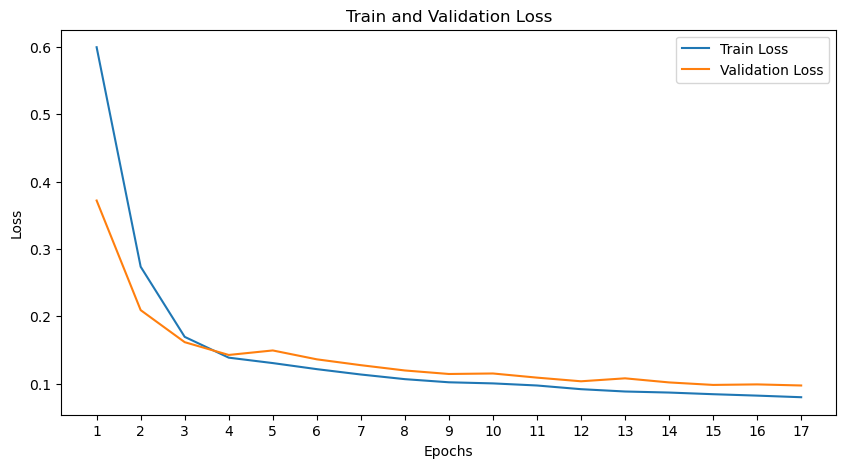

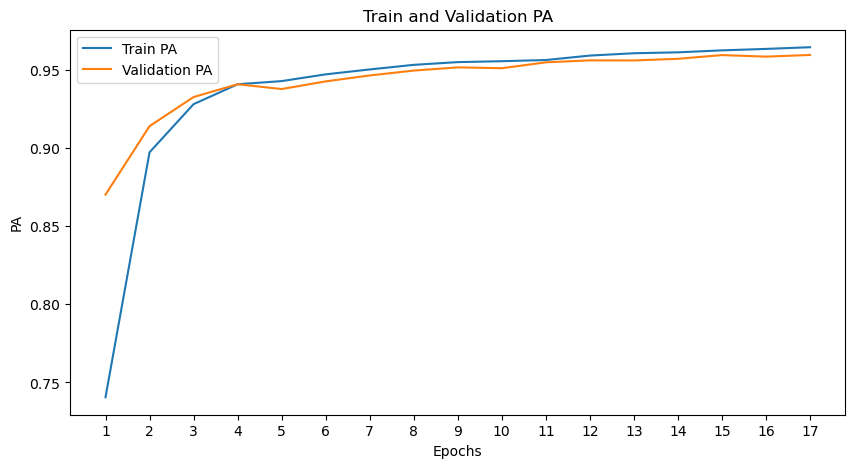

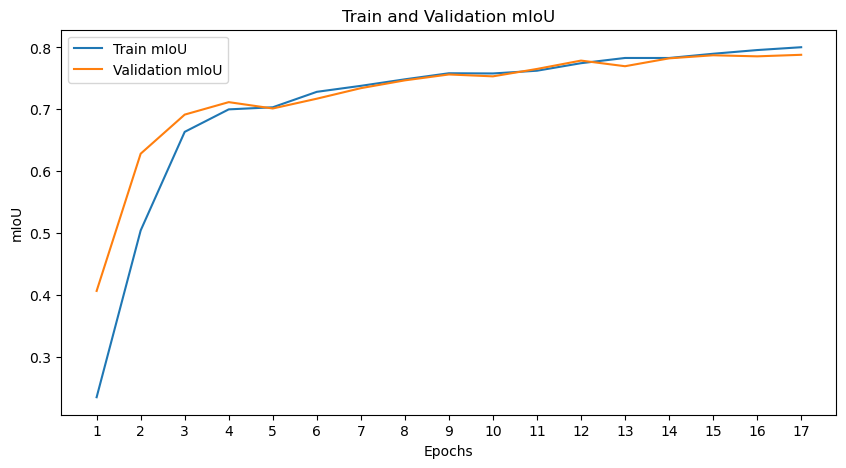

In [82]:
def plots(r, save_file, data_name):
    os.makedirs(save_file, exist_ok=True)  # Ensure the save directory exists
    
    metrics = [("Loss", "tr_loss", "val_loss"), 
               ("PA", "tr_pa", "val_pa"), 
               ("mIoU", "tr_IoU", "val_IoU")]

    for title, train_metric, val_metric in metrics:
        plt.figure(figsize=(10, 5))
        plt.plot(r[train_metric], label=f"Train {title}")
        plt.plot(r[val_metric], label=f"Validation {title}")
        plt.title(f"Train and Validation {title}")
        plt.xticks(np.arange(len(r[val_metric])), range(1, len(r[val_metric])+1))
        plt.xlabel("Epochs")
        plt.ylabel(title)
        # plt.ylim(0.8, 1)
        plt.legend()
        plt.savefig(f"{save_file}/{data_name}_{title}.png")  # Save the plot as an image
        plt.show()

# Example usage
plots(result, save_file="plots_directory", data_name="Dental_Caries")


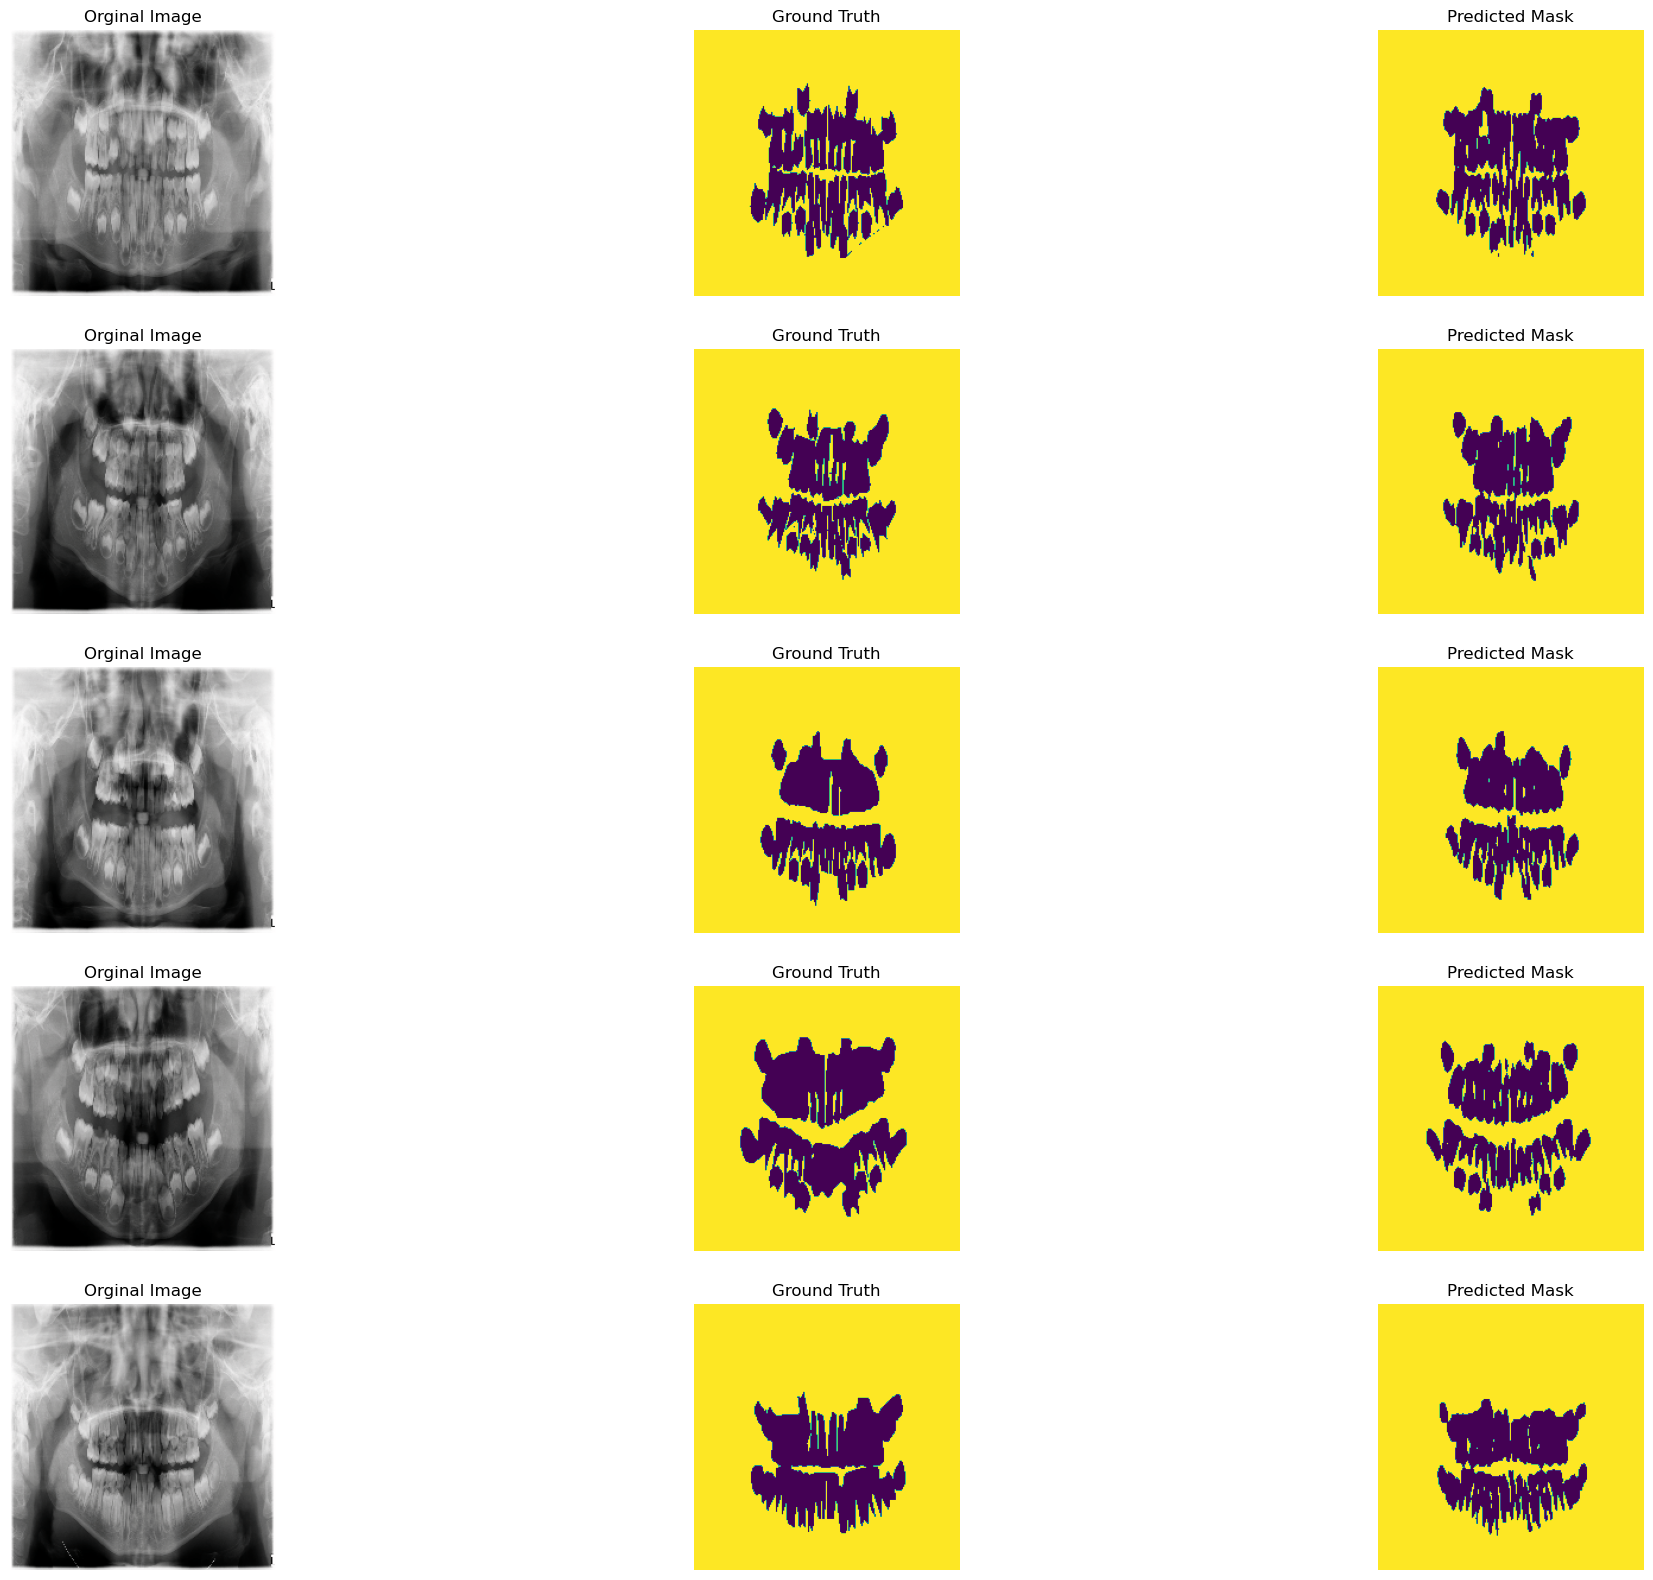

In [84]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = ploting(cols, rows, count, im)

        # Second plot
        count = ploting(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = ploting(cols, rows, count, im = pred, title = "Predicted Mask")

# model = torch.load("saved_models/dental_best_model.pt")
model.load_state_dict(torch.load("Dental_best_model/Dental_Caries_best.pt"))

inference(ts_dl, model = model, device = device)